In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q seaborn
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
BATCH_SIZE = 32
n_classes = 6

# VGG16 base model
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze all layers except the last two
for layer in conv_base.layers[:-2]:
    layer.trainable = False

# Top model
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(1024, activation='relu')(top_model)  # Increased units
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512, activation='relu')(top_model)  # Increased units
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)

In [2]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)

    # Get random indices for selecting images
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Plot the selected images
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]
        # Ensure pixel values are in valid range [0, 1]
        image = np.clip(image, 0, 1)

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

In [3]:
data_path = '../relabelled_garbage_classification_with_775_images'

Found 4650 images belonging to 6 classes.


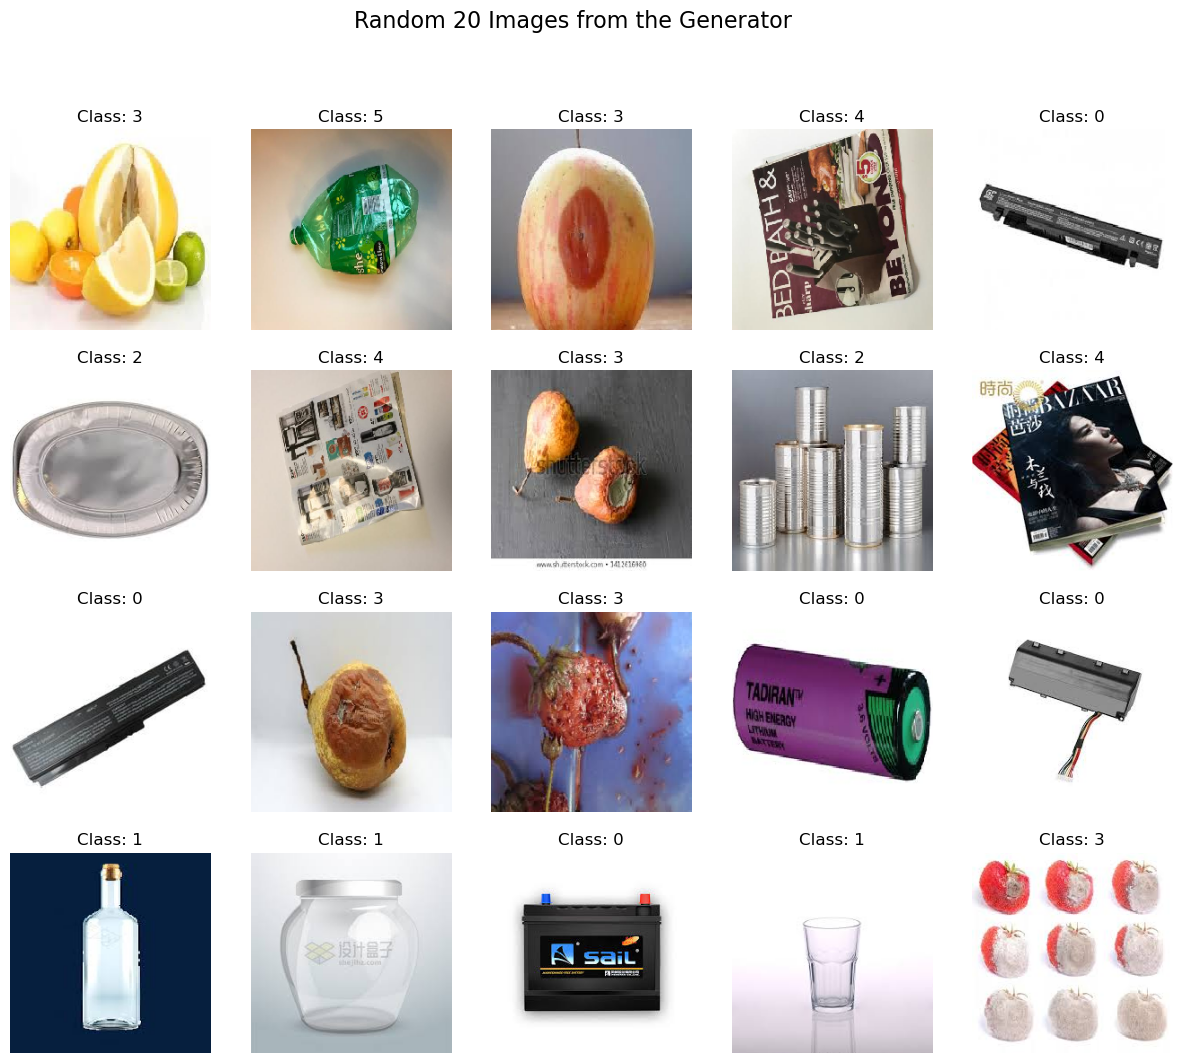

In [4]:
original_data = ImageDataGenerator(rescale=1./255).flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(original_data)

Found 4650 images belonging to 6 classes.


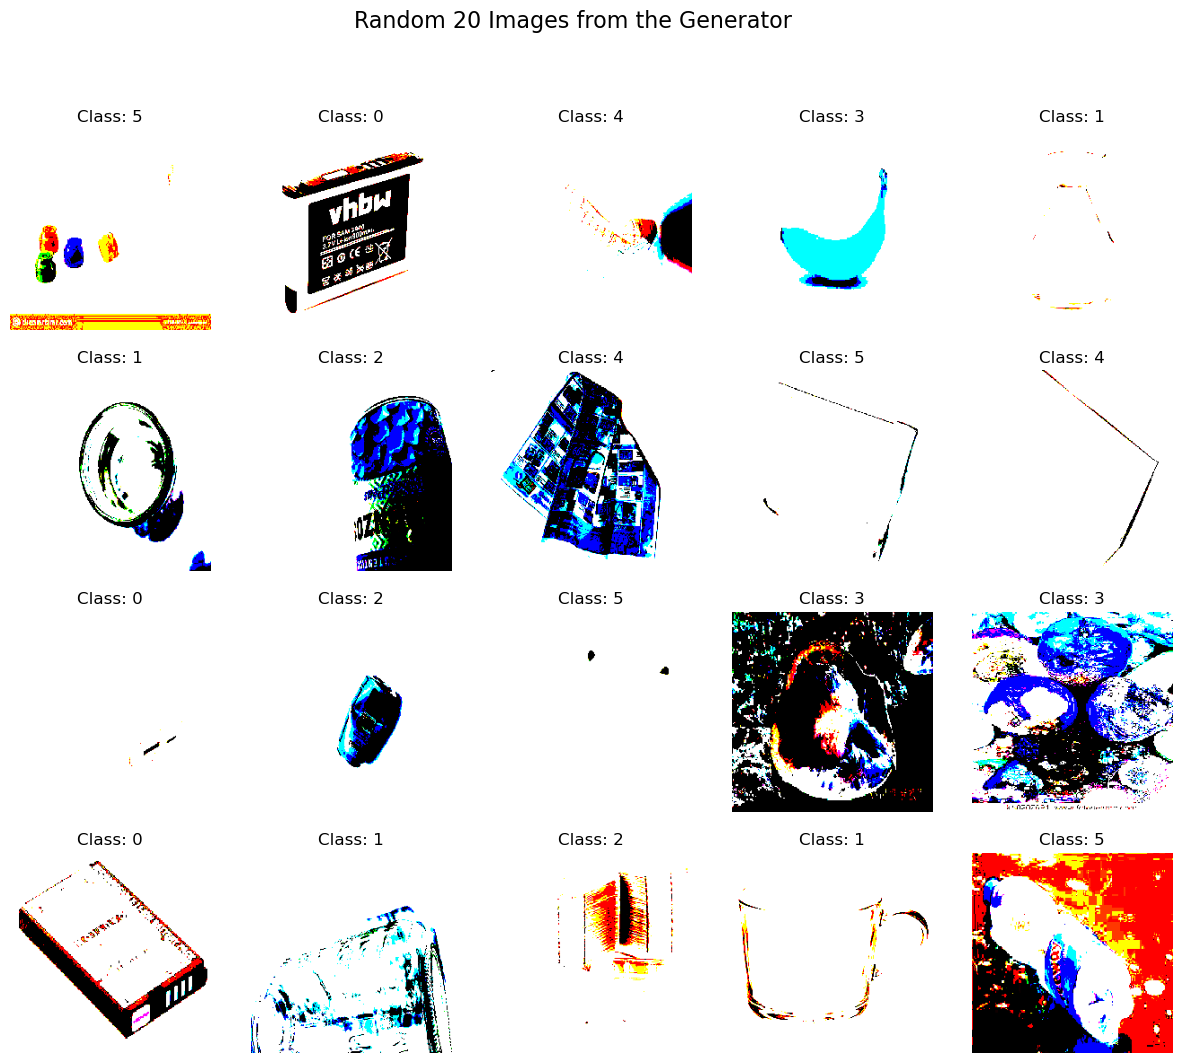

In [5]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

In [6]:
# Extract filenames and labels from the DirectoryIterator
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

filenames[:5], labels[:5]

(['battery\\battery1.jpg',
  'battery\\battery10.jpg',
  'battery\\battery100.jpg',
  'battery\\battery101.jpg',
  'battery\\battery102.jpg'],
 ['battery', 'battery', 'battery', 'battery', 'battery'])

In [7]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.1, random_state=42)

# Create DataFrames for training and testing
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 4185 validated image filenames belonging to 6 classes.
Found 465 validated image filenames belonging to 6 classes.


In [8]:
num_epochs = 200
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    filepath='model.best.h5',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
n_steps = train_data.samples // BATCH_SIZE
n_val_steps = test_data.samples // BATCH_SIZE
n_steps, n_val_steps

(130, 14)

In [11]:
result = model.fit(
    train_data, 
    epochs=num_epochs, 
    steps_per_epoch=n_steps,
    validation_data=test_data, 
    validation_steps=n_val_steps,
    callbacks=[early, checkpoint, reduce_lr]
)

Epoch 1/200
130/130 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.7472
Epoch 1: val_loss improved from inf to 0.28246, saving model to model.best.h5
130/130 [==============================] - 45s 225ms/step - loss: 0.7877 - accuracy: 0.7472 - val_loss: 0.2825 - val_accuracy: 0.9152 - lr: 1.0000e-04
Epoch 2/200
130/130 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.9150
Epoch 2: val_loss improved from 0.28246 to 0.21557, saving model to model.best.h5
130/130 [==============================] - 22s 169ms/step - loss: 0.2459 - accuracy: 0.9150 - val_loss: 0.2156 - val_accuracy: 0.9330 - lr: 1.0000e-04
Epoch 3/200
130/130 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9485
Epoch 3: val_loss improved from 0.21557 to 0.18433, saving model to model.best.h5
130/130 [==============================] - 21s 164ms/step - loss: 0.1494 - accuracy: 0.9485 - val_loss: 0.1843 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 4/200
13

Epoch 28/200
130/130 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9981
Epoch 28: val_loss did not improve from 0.15975
130/130 [==============================] - 22s 172ms/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.1630 - val_accuracy: 0.9442 - lr: 1.0000e-06
Epoch 29/200
130/130 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9990
Epoch 29: val_loss did not improve from 0.15975
130/130 [==============================] - 21s 158ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.1642 - val_accuracy: 0.9464 - lr: 1.0000e-06
Epoch 30/200
130/130 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9976
Epoch 30: val_loss did not improve from 0.15975
130/130 [==============================] - 20s 151ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.1639 - val_accuracy: 0.9464 - lr: 1.0000e-06
Epoch 31/200
130/130 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9983
Epoch 31: v

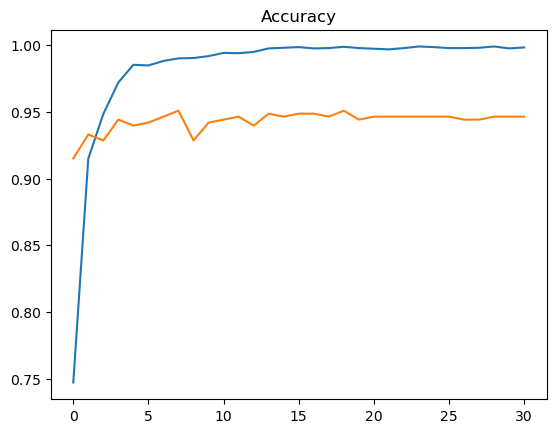

In [12]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.show()

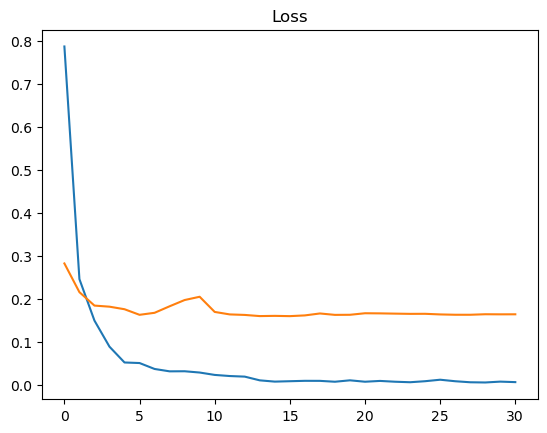

In [13]:
plt.title("Loss")
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.show()

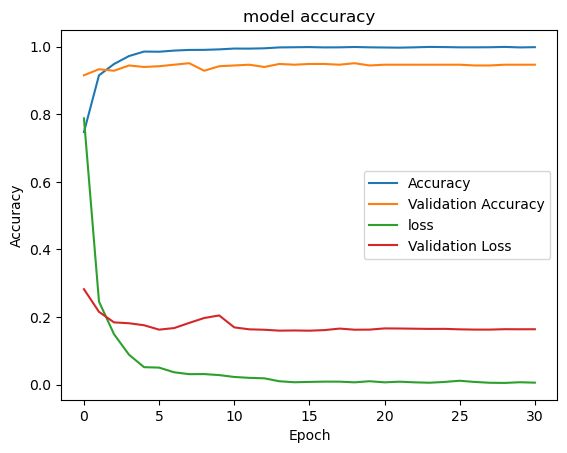

In [14]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [15]:
model.save("model.h5")

15/15 [==============================] - 5s 341ms/step


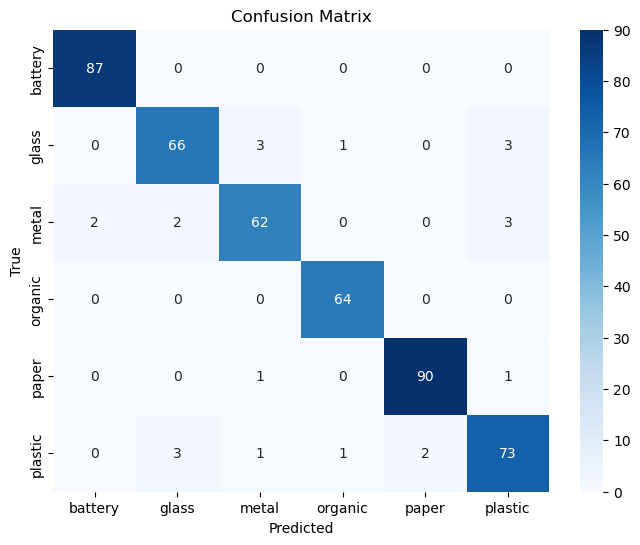

              precision    recall  f1-score   support

     battery       0.98      1.00      0.99        87
       glass       0.93      0.90      0.92        73
       metal       0.93      0.90      0.91        69
     organic       0.97      1.00      0.98        64
       paper       0.98      0.98      0.98        92
     plastic       0.91      0.91      0.91        80

    accuracy                           0.95       465
   macro avg       0.95      0.95      0.95       465
weighted avg       0.95      0.95      0.95       465



In [16]:
predictions = model.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [17]:
output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

## Train with new data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


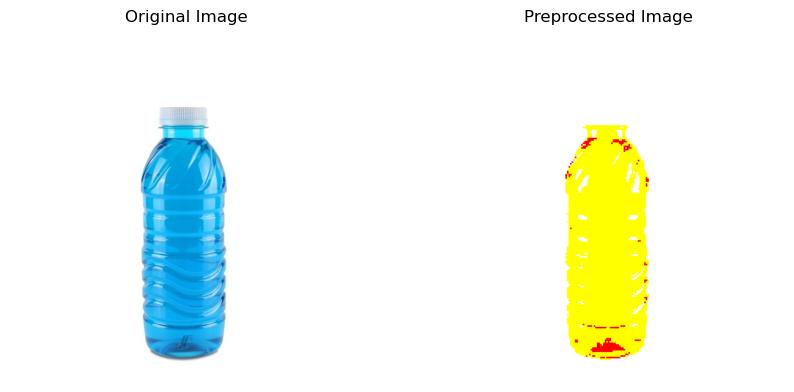

1/1 [==============================] - 0s 62ms/step
Your waste material is plastic with 100.0 % accuracy.


In [19]:
predict_user('botol.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


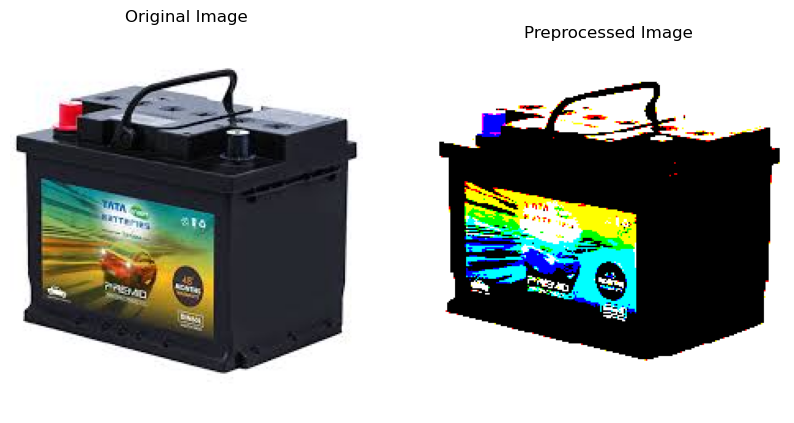

1/1 [==============================] - 0s 66ms/step
Your waste material is battery with 100.0 % accuracy.


In [20]:
predict_user('battery.jpeg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


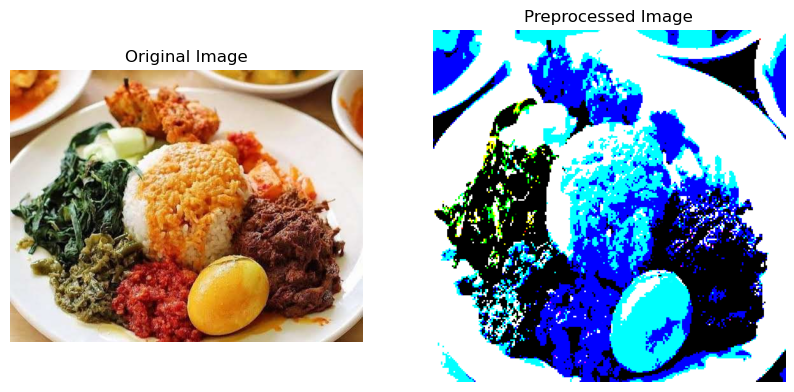

1/1 [==============================] - 0s 63ms/step
Your waste material is organic with 100.0 % accuracy.


In [21]:
predict_user('naspad.jpeg')